<a href="https://colab.research.google.com/github/Kushagra-1/Time-Series-Price-prediction-moving-average-/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import json

def fetch_daily_data(symbol):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)

    else:
        print("Did not receieve OK response from Coinbase API")


if __name__ == "__main__":
    # we set which pair we want to retrieve data for
    pair = "ETH/USD"
    fetch_daily_data(symbol=pair)

In [2]:
df = pd.read_csv('/content/Coinbase_ETHUSD_dailydata.csv')
df.head()

,unix,low,high,open,close,volume,date,vol_fiat
0,1633392000,3365.34,3476.03,3386.90,3422.43,85776.109570,2021-10-05,2.935627e+08
1,1633305600,3269.67,3438.91,3419.63,3387.20,163829.626778,2021-10-04,5.549237e+08
2,1633219200,3343.36,3489.18,3388.67,3420.07,124271.048646,2021-10-03,4.250157e+08
3,1633132800,3258.94,3469.95,3311.20,3387.82,144778.384500,2021-10-02,4.904831e+08
4,1633046400,2967.41,3337.15,3001.14,3311.16,201035.513451,2021-10-01,6.656608e+08


In [3]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [4]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,unix,low,high,open,close,volume,date,vol_fiat,month
299,1607558400,547.83,575.62,573.26,559.45,117320.210568,2020-12-10,6.563479e+07,12
298,1607644800,535.50,560.62,559.33,544.23,173696.260257,2020-12-11,9.453072e+07,12
297,1607731200,543.22,574.33,544.51,568.64,101618.146587,2020-12-12,5.778414e+07,12
296,1607817600,563.79,595.21,568.64,590.75,105159.234252,2020-12-13,6.212282e+07,12
295,1607904000,575.58,591.71,590.45,586.39,103488.316311,2020-12-14,6.068451e+07,12
294,1607990400,579.15,597.04,586.40,589.08,95567.386381,2020-12-15,5.629684e+07,12
293,1608076800,581.21,639.58,589.08,637.98,261818.288602,2020-12-16,1.670348e+08,12
292,1608163200,626.79,677.05,637.91,643.37,430253.082708,2020-12-17,2.768119e+08,12
291,1608249600,629.59,664.46,643.26,654.66,177136.019038,2020-12-18,1.159639e+08,12
290,1608336000,646.54,672.06,654.66,658.96,186815.555087,2020-12-19,1.231040e+08,12


Text(0, 0.5, 'USD')

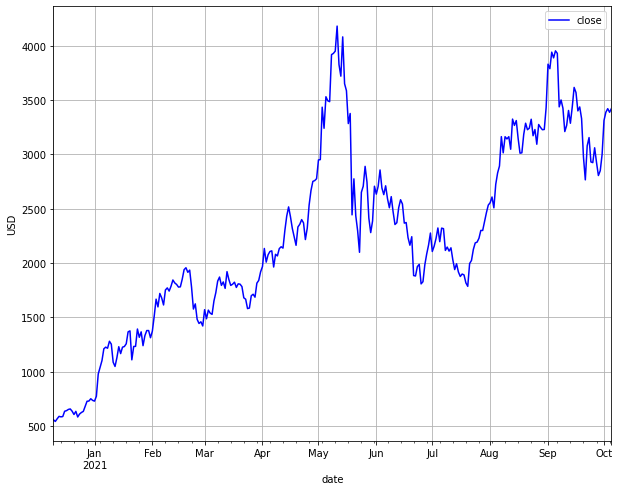

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [10]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 180
num_cv = 60
num_test = 60
train.shape = (180, 9)
cv.shape = (60, 9)
train_cv.shape = (240, 9)
test.shape = (60, 9)


Text(0, 0.5, 'USD')

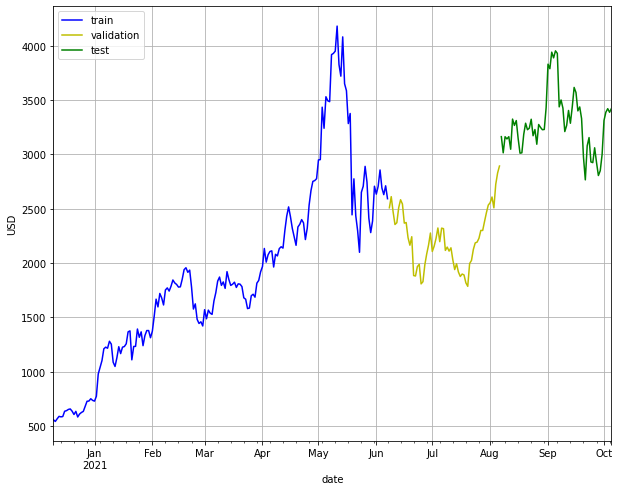

In [12]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [13]:

RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    mape.append(get_mape(cv['close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [106.07613021630569, 118.96786418328838, 130.05270965821677, 143.07384894223594, 158.36728509112388, 173.07533228390793, 187.7902518610793, 202.6783327293986, 215.5499744849746, 226.54134364908617, 236.9911338339086, 246.578709895378, 254.9557727890499, 262.3640572782342, 270.0614091041902, 277.16281689873864, 283.0868015007442, 287.7377621660963, 291.03939625779964, 293.27821027008645, 295.4927780482073]
MAPE = [3.8300420583718, 4.620233280257901, 5.103522946712248, 5.53221854028926, 6.276947409910629, 7.02731040959358, 7.634295630202101, 8.237292071388245, 8.774698298432861, 9.224282661783116, 9.54992652287095, 9.841526636660912, 10.046672805631115, 10.227285881247054, 10.367128937088886, 10.476116304212185, 10.587359935185447, 10.653089076772753, 10.662810447417506, 10.631892316264423, 10.61790856307216]


,unix,low,high,open,close,volume,date,vol_fiat,month
299,1607558400,547.83,575.62,573.26,559.45,117320.210568,2020-12-10,6.563479e+07,12
298,1607644800,535.50,560.62,559.33,544.23,173696.260257,2020-12-11,9.453072e+07,12
297,1607731200,543.22,574.33,544.51,568.64,101618.146587,2020-12-12,5.778414e+07,12
296,1607817600,563.79,595.21,568.64,590.75,105159.234252,2020-12-13,6.212282e+07,12
295,1607904000,575.58,591.71,590.45,586.39,103488.316311,2020-12-14,6.068451e+07,12


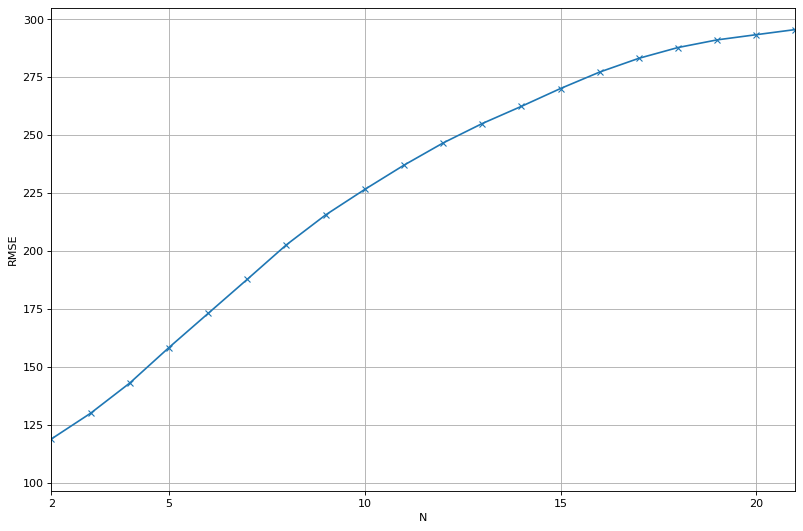

In [14]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x7fc8ffee0dd0>,
 <a list of 5 Text major ticklabel objects>)

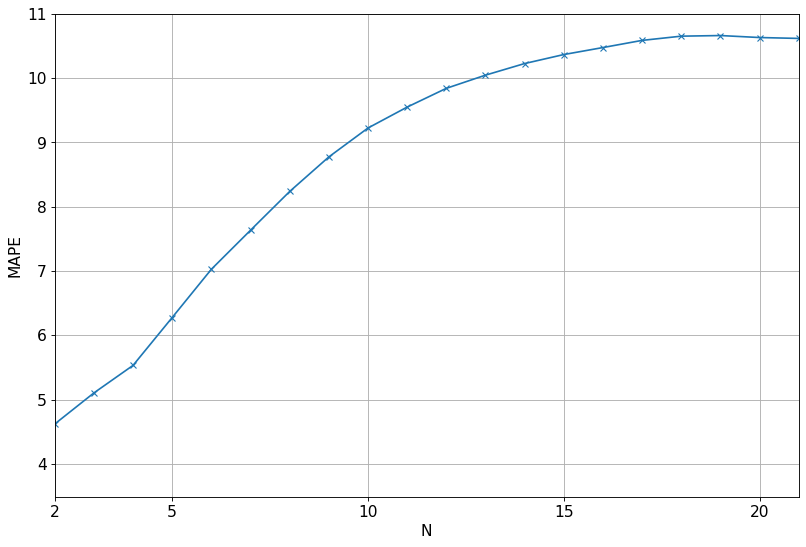

In [16]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [17]:

# Set optimum N
N_opt = 2

Text(0, 0.5, 'USD')

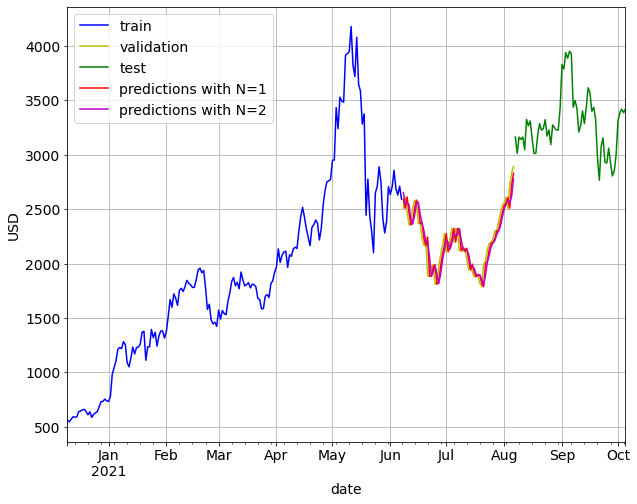

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

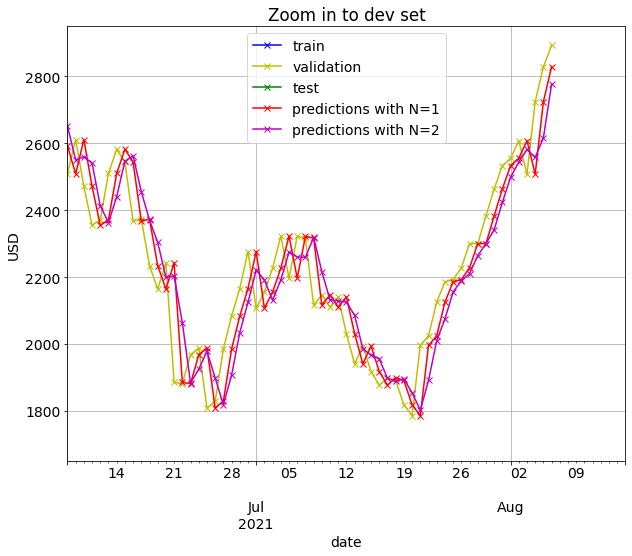

In [28]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 6, 8), date(2021, 8, 15)])
ax.set_ylim([1650, 2950])
ax.set_title('Zoom in to dev set')

In [29]:
est_list = get_preds_mov_avg(df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("MAPE = %0.3f%%" % get_mape(test['close'], est_list))
test.head()

RMSE = 180.323
MAPE = 4.154%


,unix,low,high,open,close,volume,date,vol_fiat,month,est_N2
59,1628294400,2866.58,3173.72,2892.83,3163.09,299359.362437,2021-08-07,9.469006e+08,8,2861.165
58,1628380800,2948.76,3191.99,3163.09,3014.13,244654.458761,2021-08-08,7.374203e+08,8,3028.035
57,1628467200,2892.50,3190.00,3014.12,3162.34,315853.326651,2021-08-09,9.988356e+08,8,3088.610
56,1628553600,3051.00,3235.10,3162.33,3142.09,223500.031889,2021-08-10,7.022572e+08,8,3088.235
55,1628640000,3122.22,3275.00,3142.18,3162.61,194586.917864,2021-08-11,6.154025e+08,8,3152.215


Text(0, 0.5, 'USD')

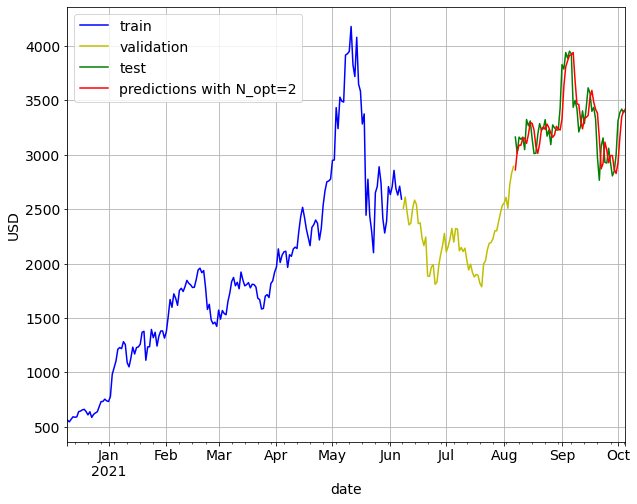

In [30]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

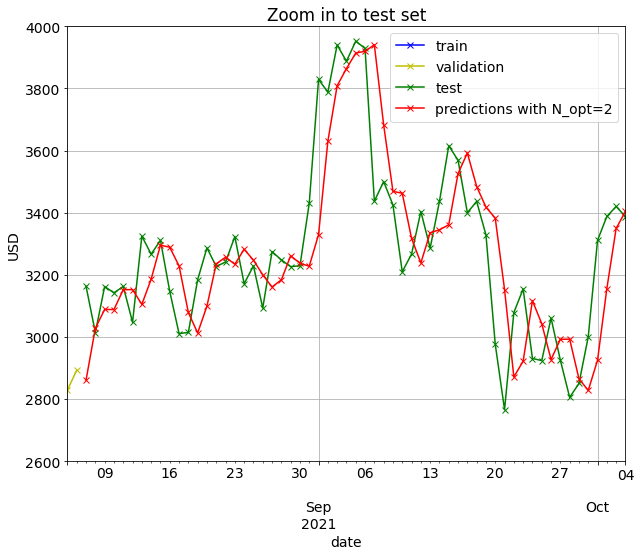

In [32]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 8, 5), date(2021, 10, 4)])
ax.set_ylim([2600, 4000])
ax.set_title('Zoom in to test set')